<a href="https://colab.research.google.com/github/becak123/ProjeckARVR/blob/main/Analisis_data_cuaca_BMKG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

💾 Dashboard disimpan: DASHBOARD_KALBAR_20260129_1210.png


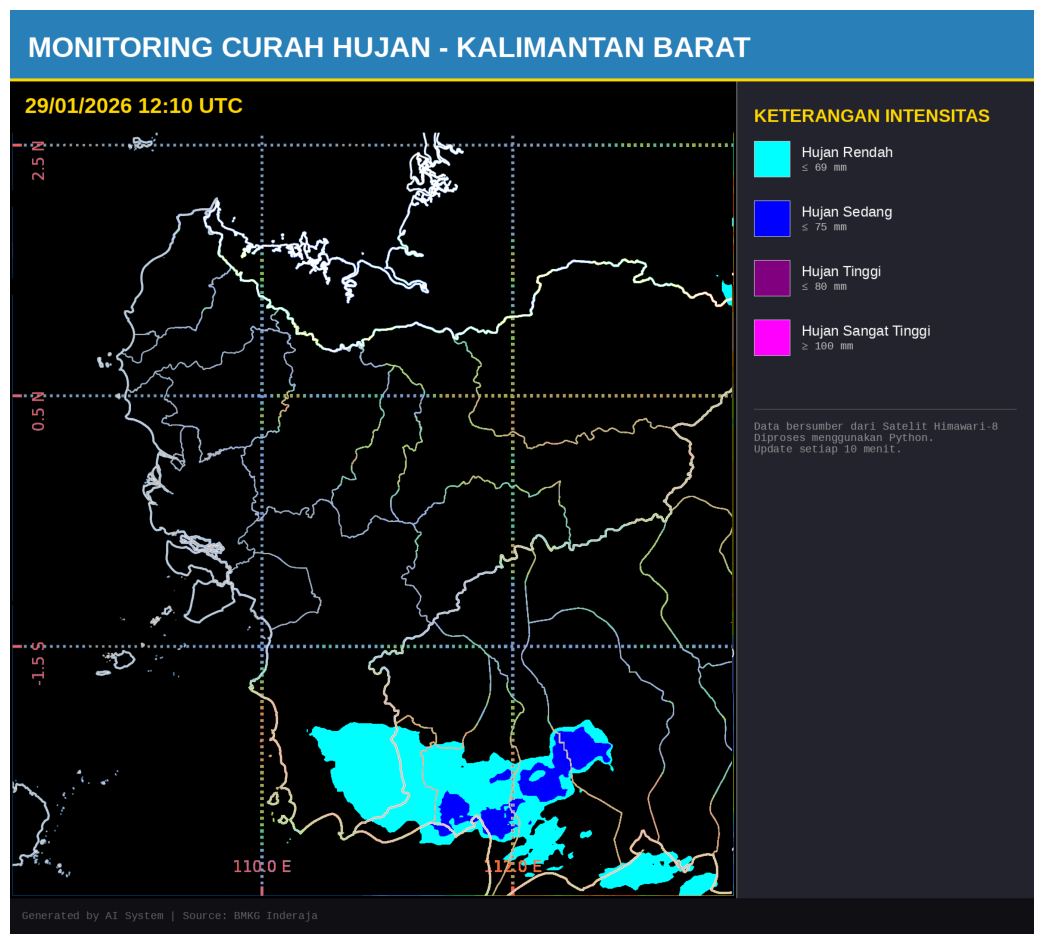

✅ Update Dashboard Sukses: 29/01/2026 12:10 UTC


In [ ]:

import os
import time
import requests
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont, ImageFile
from io import BytesIO
from datetime import datetime, timedelta
from IPython.display import clear_output


try:
    import easyocr
except ImportError:
    os.system('pip install easyocr opencv-python-headless')

ImageFile.LOAD_TRUNCATED_IMAGES = True


COLOR_BG        = (25, 25, 35, 255)
COLOR_HEADER    = (41, 128, 185, 255)
COLOR_SIDEBAR   = (35, 35, 45, 255)
COLOR_TEXT_MAIN = (255, 255, 255, 255)
COLOR_TEXT_ACC  = (255, 215, 0, 255)
COLOR_COVER     = (0, 0, 0, 255)


LEGEND_WIDTH = 500
HEADER_HEIGHT = 120
FOOTER_HEIGHT = 60
COVER_HEIGHT  = 85


def update_map_stylish():

    url_cloud = "https://inderaja.bmkg.go.id/IMAGE/HIMA/H08_EH_Kalbar.png"
    try:
        response = requests.get(url_cloud, stream=True, timeout=60)
        response.raise_for_status()
    except Exception as e:
        print(f"⚠️ Gagal download gambar: {e}")
        return


    img_source = Image.open(BytesIO(response.content)).convert("RGBA")
    img_np = np.array(img_source)


    h, w, _ = img_np.shape
    cut_start = w - 160
    cut_end   = w - 7
    cropped = np.concatenate((img_np[:, :cut_start], img_np[:, cut_end:]), axis=1)


    rules = [
        ((250, 88, 88), (128, 0, 128, 255)), ((254, 0, 0), (255, 0, 255, 255)),
        ((255, 212, 184), (0, 0, 255, 255)), ((255, 196, 141), (0, 255, 255, 255)),
        ((72, 135, 255), (0, 0, 0, 255)), ((140, 255, 0), (0, 0, 0, 255)),
        ((0, 230, 134), (0, 0, 0, 255)), ((67, 176, 255), (0, 0, 0, 255)),
        ((52, 98, 180), (0, 0, 0, 255)), ((10, 72, 130), (0, 0, 0, 255)),
        ((0, 192, 145), (0, 0, 0, 255)), ((197, 187, 0), (0, 0, 0, 255)),
        ((205, 154, 0), (0, 0, 0, 255)), ((255, 93, 0), (0, 0, 0, 255)),
        ((255, 160, 0), (0, 0, 0, 255)), ((156, 211, 0), (0, 0, 0, 255))
    ]

    output = cropped.copy()
    r, g, b = output[:,:,0], output[:,:,1], output[:,:,2]
    for (tr, tg, tb), (nr, ng, nb, na) in rules:
        mask = (r == tr) & (g == tg) & (b == tb)
        output[mask] = [nr, ng, nb, na]


    map_w, map_h = output.shape[1], output.shape[0]
    total_w = map_w + LEGEND_WIDTH
    total_h = map_h + HEADER_HEIGHT + FOOTER_HEIGHT


    dashboard = Image.new("RGBA", (total_w, total_h), COLOR_BG)
    draw = ImageDraw.Draw(dashboard)


    dashboard.paste(Image.fromarray(output), (0, HEADER_HEIGHT))


    now_utc = datetime.utcnow()
    delayed_time = now_utc - timedelta(minutes=10)
    rounded_minute = (delayed_time.minute // 10) * 10
    final_time = delayed_time.replace(minute=rounded_minute, second=0, microsecond=0)
    new_date_str = final_time.strftime("%d/%m/%Y %H:%M UTC")
    filename_save = f"DASHBOARD_KALBAR_{final_time.strftime('%Y%m%d_%H%M')}.png"


    try:
        font_title = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationSans-Bold.ttf", 48)

        font_map_date = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationSans-Bold.ttf", 36)
        font_legend_title = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationSans-Bold.ttf", 30)
        font_legend_item = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationSans-Regular.ttf", 24)
        font_footer = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationMono-Regular.ttf", 18)
    except:
        font_title = ImageFont.load_default()
        font_map_date = ImageFont.load_default()
        font_legend_title = ImageFont.load_default()
        font_legend_item = ImageFont.load_default()
        font_footer = ImageFont.load_default()


    draw.rectangle([0, 0, total_w, HEADER_HEIGHT], fill=COLOR_HEADER)
    draw.rectangle([0, HEADER_HEIGHT-5, total_w, HEADER_HEIGHT], fill=(255, 215, 0, 255))

    title_text = "MONITORING CURAH HUJAN - KALIMANTAN BARAT"
    draw.text((30, 35), title_text, font=font_title, fill=COLOR_TEXT_MAIN)


    draw.rectangle([0, HEADER_HEIGHT, map_w, HEADER_HEIGHT + COVER_HEIGHT], fill=COLOR_COVER)


    draw.text((25, HEADER_HEIGHT + 20), new_date_str, font=font_map_date, fill=COLOR_TEXT_ACC)


    sidebar_x = map_w
    draw.rectangle([sidebar_x, HEADER_HEIGHT, total_w, total_h - FOOTER_HEIGHT], fill=COLOR_SIDEBAR)
    draw.line([(sidebar_x, HEADER_HEIGHT), (sidebar_x, total_h - FOOTER_HEIGHT)], fill=(100, 100, 100, 255), width=2)

    side_pad = 30
    cursor_y = HEADER_HEIGHT + 40
    draw.text((sidebar_x + side_pad, cursor_y), "KETERANGAN INTENSITAS", font=font_legend_title, fill=COLOR_TEXT_ACC)
    cursor_y += 60

    legend_items = [
        ("Hujan Rendah", "≤ 69 mm", (0,255,255,255)),
        ("Hujan Sedang", "≤ 75 mm", (0,0,255,255)),
        ("Hujan Tinggi", "≤ 80 mm", (128,0,128,255)),
        ("Hujan Sangat Tinggi", "≥ 100 mm", (255,0,255,255))
    ]

    box_size = 60
    item_gap = 100

    for label_main, label_sub, color in legend_items:
        draw.rectangle(
            [sidebar_x + side_pad, cursor_y, sidebar_x + side_pad + box_size, cursor_y + box_size],
            fill=color, outline=(200,200,200), width=1
        )
        draw.text((sidebar_x + side_pad + box_size + 20, cursor_y + 5), label_main, font=font_legend_item, fill=COLOR_TEXT_MAIN)
        draw.text((sidebar_x + side_pad + box_size + 20, cursor_y + 35), label_sub, font=font_footer, fill=(200,200,200,255))
        cursor_y += item_gap

    cursor_y += 50
    draw.line([(sidebar_x + side_pad, cursor_y), (total_w - side_pad, cursor_y)], fill=(100,100,100,255), width=1)
    cursor_y += 20
    note = "Data bersumber dari Satelit Himawari-8\nDiproses menggunakan Python.\nUpdate setiap 10 menit."
    draw.text((sidebar_x + side_pad, cursor_y), note, font=font_footer, fill=(150,150,150,255))


    draw.rectangle([0, total_h - FOOTER_HEIGHT, total_w, total_h], fill=(15, 15, 20, 255))
    footer_text = "Generated by AI System | Source: BMKG Inderaja"
    draw.text((20, total_h - 40), footer_text, font=font_footer, fill=(100,100,100,255))


    plt.figure(figsize=(18, 12))
    plt.imshow(np.array(dashboard))
    plt.axis("off")

    dashboard.save(filename_save)
    print(f"💾 Dashboard disimpan: {filename_save}")
    plt.show()
    print(f"✅ Update Dashboard Sukses: {new_date_str}")


print("🚀 MEMULAI DASHBOARD MONITORING PRO...")
try:
    while True:
        clear_output(wait=True)
        update_map_stylish()
        time.sleep(600)
except KeyboardInterrupt:
    print("Selesai.")